<h1>Analyzing Vegetation and Water Change of the Brumadinho - 2019 Dam Failure</h1>



<h3>1. Problem Statement and Objectives</h3>

On January 25th, 2019, a tailings dam collapsed in Brumadinho, Minas Gerais, Brazil. The dam, part of the Corrego do Feijão Mine owned by Vale S.A., caused the death of 270 people and significant economic losses for the company ([source](https://en.wikipedia.org/wiki/Brumadinho_dam_disaster)). This disaster had a profound impact on the environment, particularly on vegetation and water resources.

This project aims to investigate the environmental impact of the Brumadinho dam collapse by analyzing satellite imagery from a few weeks before the incident to several years afterward (up to 2022). The primary focus is on changes in vegetation and water, using the Normalized Difference Vegetation Index (NDVI) and Normalized Difference Water Index (NDWI).

## Objectives

The objective of this project is to use NDVI and NDWI to:
1. Analyze and observe the changes in vegetation and water bodies before and after the dam collapse.
2. Assess the recovery (or lack thereof) of the affected area over time.


<h3>2. Data and methodology</h3>


- **Data Sources**: The main data source is Sentinel-2 satellite imagery, accessed via the Sentinel Hub API ([source](https://www.sentinel-hub.com/)). Additional vector data was sourced from OpenStreetMap (OSM) using the OSMnx library.
- **Pre-processing**: The data was pre-processed using Python and open-source libraries such as GeoPandas and Rasterio.
- **Indices Used**: 
  - **NDVI (Normalized Difference Vegetation Index)**: This index helps in assessing vegetation cover and health.
  - **NDWI (Normalized Difference Water Index)**: This index is used to monitor water bodies and moisture levels in vegetation.


<h3>3. Finding and Staging Data</h3>

**Importing the neccessary libraries**

In [27]:
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import folium
import rasterio
import mapclassify
import os
import shutil
import zipfile
from matplotlib.colors import ListedColormap
from IPython.display import Image, display
import imageio.v2 as imageio
from IPython.display import Image, display, HTML

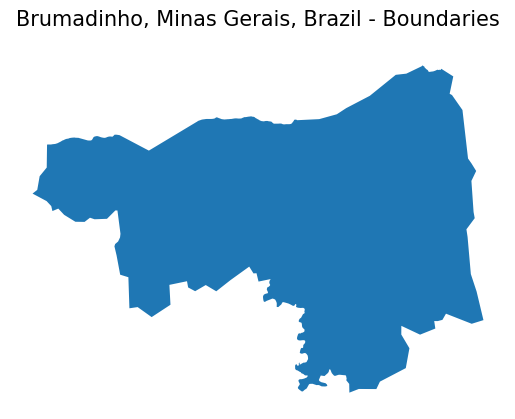

In [6]:
#Extracting the study area Map using OpenStreetmap Data.
import osmnx as ox
place = "Brumadinho, Minas Gerais, Brazil"

# Geocoding the place and converting it to a GeoDataFrame
bmd = ox.geocode_to_gdf(place)
ax = ox.project_gdf(bmd).plot()

# Seting the axis off and adding  a title for context
ax.axis('off')
ax.set_title('Brumadinho, Minas Gerais, Brazil - Boundaries', fontsize=15)
plt.show()


In [3]:
#Getting some attribute of the study area
bmd

geometry  bbox_north  bbox_south  \
0  POLYGON ((-44.35000 -20.15900, -44.33800 -20.1...  -20.054255     -20.318   

   bbox_east  bbox_west  place_id  osm_type  osm_id        lat   lon  \
0    -43.965     -44.35  41188691  relation  314762 -20.143611 -44.2   

      class            type  place_rank  importance   addresstype        name  \
0  boundary  administrative          16    0.477156  municipality  Brumadinho   

                                        display_name  
0  Brumadinho, Região Geográfica Imediata de Belo...

In [18]:

# Defining  the place name and geocoding it
place = "Brumadinho, Minas Gerais, Brazil"
bmd = ox.geocode_to_gdf(place)

# Adding additional attributes to the geodataframe
bmd['country'] = 'Brazil'
bmd['state'] = 'Minas Gerais'
bmd['population'] = 40666
bmd['total_area_sq_mi'] = 247160
bmd['total_area_sq_km'] = 640150

# Creating a Wikipedia link 
url = 'https://en.wikipedia.org/wiki/Brumadinho'
link = f'<a href="{url}" rel="noopener noreferrer" target="_blank">See More</a>'
bmd['wiki'] = link

# Geocoding  a specific location close to the dam. This place is very close to the dam and it serves as the place
# of memorial for the people who lost their lives
corrego = gpd.tools.geocode('Vale Mina Córrego do Feijão, Brumadinho, Minas Gerais, Brazil')
corrego['event_date'] = '25 Jan 2019'
corrego['event'] = 'Dam Failure'
corrego['deaths'] = 270

# Creating a Wikipedia link for the dam disaster 
crg_url = 'https://en.wikipedia.org/wiki/Brumadinho_dam_disaster'
crg_link = f'<a href="{crg_url}" rel="noopener noreferrer" target="_blank">See More</a>'
corrego['wiki'] = crg_link

# Creating a map and adding  the GeoDataFrames with additional layers and tooltips
# The map is then displayed using the OpenStreetA
place_map = bmd.explore(
    name='Brumadinho',
    color='green',
    tooltip=["name", "addresstype", "lat", "lon"],
    legend_kwds=dict(colorbar=False),
    popup=['lat', 'lon', 'addresstype', 'name', 'country', 'state', 
           'population', 'total_area_sq_mi', 'total_area_sq_km', 'wiki'],
    legend=True
)

corrego.explore(
    m=place_map,
    color="red",
    marker_kwds=dict(radius=10, fill=True),
    tooltip="address",
    tooltip_kwds=dict(labels=False),
    popup=['event_date', 'event', 'deaths', 'wiki'],
    name="Mine",
    legend=True
)

# Adding additional tile layers and layer control
folium.TileLayer("CartoDB positron", show=False).add_to(place_map)
folium.LayerControl().add_to(place_map)

# Displaying  the map
place_map


<h3>3. Exploring Sentinel Data</h3>

<p>The Sentinel data was downloaded using the Sentinel Hub API. This study focused only on the visible bands of the electromagnetic spectrum, specifically the Red, Green, and Blue bands. These bands were selected because they are necessary for the calculations of the indices analyzed in the study. The imagery has a spatial resolution of 10 meters and a temporal resolution of 5 days.</p>


In [ ]:
# To make the code modular and easily maintainable, data processing functions (methods) 
# will be defined using the object-oriented programming paradigm.


In [25]:
import os
import imageio
import matplotlib.pyplot as plt
import numpy as np
import rasterio
from IPython.display import display, HTML

class GeospatialProcessor:
    """
    This class contains useful methods needed for the processing of Sentinel-2 satellite imagery.
    """
    def __init__(self, path):
        if not os.path.exists(path):
            raise FileNotFoundError(f"The file {path} does not exist.")
        self.path = path
        self.data = self.load_band(path)

    def load_band(self, path):
        """
        Method for loading a particular band of the imagery.
        """
        with rasterio.open(path) as src:
            return src.read()

    @staticmethod
    def calculate_ndvi(nir_band, red_band):
        """
        Method for calculating the NDVI. The arbitrary small number (1e-10) is added to ensure numerical stability
        and prevent division by zero. The NDVI index requires the near-infrared band and the red band.
        """
        nir_band = nir_band.astype(np.float64)
        red_band = red_band.astype(np.float64)
        ndvi = (nir_band - red_band) / (nir_band + red_band + 1e-10)
        return ndvi

    @staticmethod
    def calculate_ndwi(green_band, nir_band):
        """
        Method for calculating NDWI. The NDWI index requires the green band and the near-infrared band.
        """
        green_band = green_band.astype(np.float64)
        nir_band = nir_band.astype(np.float64)
        ndwi = (green_band - nir_band) / (green_band + nir_band + 1e-10)
        return ndwi

    @staticmethod
    def save_img(filename, img_data, metadata_src, dest_folder):
        """
        Method for saving the image.
        """
        with rasterio.open(metadata_src) as src:
            kwargs = src.meta.copy()
            kwargs.update({'dtype': rasterio.float64})

        if not os.path.exists(dest_folder):
            os.makedirs(dest_folder)

        with rasterio.open(os.path.join(dest_folder, f'{filename}.tif'), 'w', **kwargs) as dst:
            dst.write(img_data)

    @staticmethod
    def quick_viz(band, title):
        """
        Method for quick visualization of a band.
        """
        band_new = np.ma.masked_where(band == 0, band, copy=True).squeeze()
        plt.figure(figsize=(8, 6))
        img = plt.imshow(band_new, cmap='RdYlGn')
        cbar = plt.colorbar(img, orientation='horizontal', fraction=0.036, pad=0.1)
        cbar.set_label(title)
        plt.axis('off')  
        plt.title(title)
        plt.show()

    @staticmethod
    def band_stats(band):
        """
        Method for calculating band statistics.
        """
        stats = {
            'min': band.min(),
            'mean': band.mean(),
            'median': np.median(band),
            'max': band.max()
        }
        print(stats)

    @staticmethod
    def process_ndvi_ndwi(base_path, output_folder, meta_src):
        """
        Method to iterate through directories, read the files, and process NDVI and NDWI.
        """
        # Listing all subdirectories in the base path
        dates = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

        for date in dates:
            date_path = os.path.join(base_path, date)
            # Extracting the timestamp from one of the filenames in the directory
            sample_file = [f for f in os.listdir(date_path) if f.endswith('_B03_10m.tif')][0]
            timestamp = sample_file.split('_')[1]

            # Paths to the bands
            green_band_path = os.path.normpath(os.path.join(date_path, f'T23KNT_{timestamp}_B03_10m.tif'))
            nir_band_path = os.path.normpath(os.path.join(date_path, f'T23KNT_{timestamp}_B08_10m.tif'))
            red_band_path = os.path.normpath(os.path.join(date_path, f'T23KNT_{timestamp}_B04_10m.tif'))

            # Debugging prints to confirm the paths
            print(f"Checking files for date: {date}")
            print(f"Green band path: {green_band_path}")
            print(f"NIR band path: {nir_band_path}")
            print(f"Red band path: {red_band_path}")

            # Ensuring the files exist before proceeding
            if not all(os.path.exists(path) for path in [green_band_path, nir_band_path, red_band_path]):
                print(f"Skipping {date} due to missing files.")
                continue

            # Creating an instance of GeospatialProcessor
            processor = GeospatialProcessor(nir_band_path)  # Example path for initialization

            # Loading bands
            green_band = processor.load_band(green_band_path)
            nir_band = processor.load_band(nir_band_path)
            red_band = processor.load_band(red_band_path)

            # Calculating NDVI and NDWI
            ndvi = processor.calculate_ndvi(nir_band, red_band)
            ndwi = processor.calculate_ndwi(green_band, nir_band)

            # Saving images
            processor.save_img(f'ndvi_{date}', ndvi, meta_src, output_folder)
            processor.save_img(f'ndwi_{date}', ndwi, meta_src, output_folder)

            # Printing stats and visualizing
            print(f'NDVI Stats for {date}')
            processor.band_stats(ndvi)
            processor.quick_viz(ndvi, f'NDVI {date}')

            print(f'NDWI Stats for {date}')
            processor.band_stats(ndwi)
            processor.quick_viz(ndwi, f'NDWI {date}')

    @staticmethod
    def create_animation(input_dir, output_gif, cmap, colorbar_label):
        """
        Method for creating animations of NDVI and NDWI.
        """
        try:
            input_dir_path = os.path.abspath(input_dir)
            print(f"Checking input directory: {input_dir_path}")  # Debug statement

            if not os.path.exists(input_dir_path):
                raise FileNotFoundError(f"The input directory {input_dir_path} does not exist.")
            
            image_list = [file for file in os.listdir(input_dir_path) if file.endswith('.tif')]
            
            if not image_list:
                raise FileNotFoundError(f"No TIFF images found in the input directory {input_dir_path}.")
            
            images = []
            for img in image_list:
                try:
                    with rasterio.open(os.path.join(input_dir_path, img)) as src:
                        lcpri_img = src.read(1)

                    lcpri_img = np.ma.masked_where(lcpri_img == 0, lcpri_img, copy=True)
                    plt.figure(figsize=(10, 10))
                    plt.imshow(lcpri_img, cmap=cmap, vmin=-1.0, vmax=1.0)
                    parts = img.split('.')
                    filename = parts[0]
                    print(f'Processing: {filename}')
                    plt.title(filename, fontsize=20, fontweight='bold')
                    cur_axes = plt.gca()
                    cur_axes.axes.get_xaxis().set_visible(False)
                    cur_axes.axes.get_yaxis().set_visible(False)
                    cb = plt.colorbar(orientation='horizontal')
                    cb.set_label(colorbar_label, size=20)
                    cb.ax.tick_params(labelsize=18)
                    plt.tight_layout()
                    plt.savefig(f'{filename}.png', dpi=150)
                    plt.close()

                    images.append(imageio.imread(f'{filename}.png'))
                    os.remove(f'{filename}.png')
                except Exception as e:
                    print(f"Error processing image {img}: {e}")
                    continue

            if not images:
                raise ValueError(f"No images to compile into GIF for {output_gif}.")
            
            output_gif_dir = os.path.dirname(output_gif)
            if not os.path.exists(output_gif_dir):
                os.makedirs(output_gif_dir)
            
            # Creating GIF with loop and reduced speed.The speed can be modified to a desired value
            imageio.mimsave(output_gif, images, duration=1.5, loop=0)  
        except Exception as e:
            print(f"Error creating animation: {e}")



**Exploring and Visualizing the Imagery before the event**

Green
{'min': 0, 'mean': 322.4939279759179, 'median': 326.0, 'max': 16560}


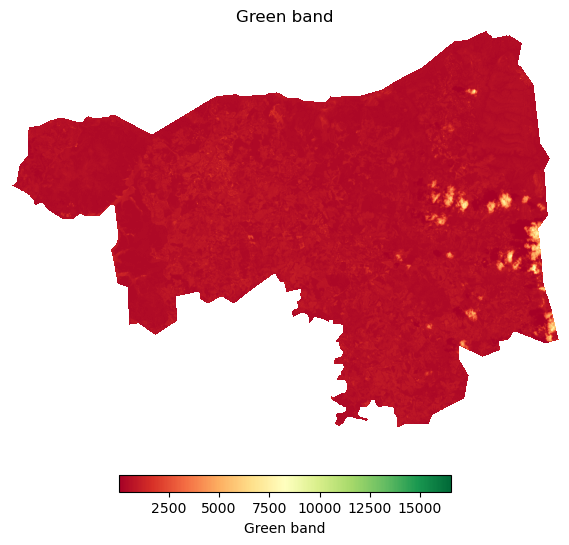

NIR
{'min': 0, 'mean': 1488.615851773011, 'median': 1836.0, 'max': 15456}


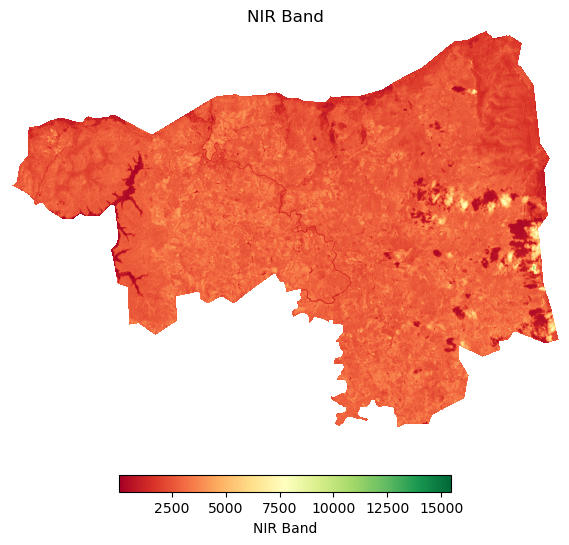

Red
{'min': 0, 'mean': 256.07925715662225, 'median': 180.0, 'max': 16016}


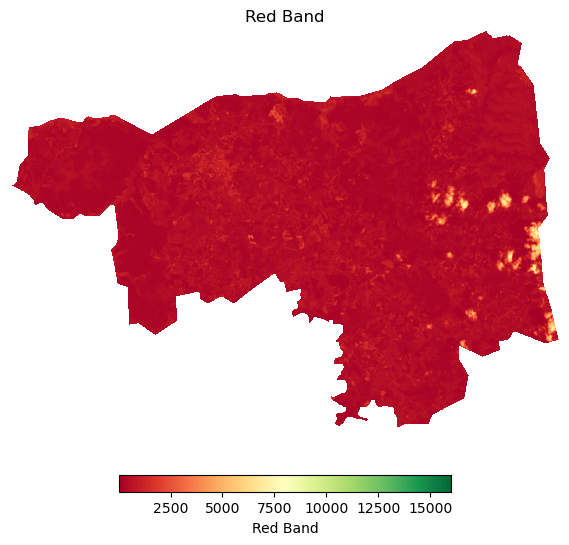

In [19]:
# Paths to the  bands
green_band_path = './data/S2_20190107/T23KNT_20190107T131239_B03_10m.tif'
nir_band_path = './data/S2_20190107/T23KNT_20190107T131239_B08_10m.tif'
red_band_path = './data/S2_20190107/T23KNT_20190107T131239_B04_10m.tif'

# Create an instance of GeospatialProcessor with any valid path
# The path used here is arbitrary, it should be any valid raster file path for initialization
# In a real-world scenario, ensure this path is valid
processor = GeospatialProcessor(green_band_path)

# Load bands using the instance method
greenband_jan_07_2k19 = processor.load_band(green_band_path)
nirband_jan_07_2k19 = processor.load_band(nir_band_path)
redband_jan_07_2k19 = processor.load_band(red_band_path)

print('Green')
GeospatialProcessor.band_stats(greenband_jan_07_2k19)
GeospatialProcessor.quick_viz(greenband_jan_07_2k19,"Green band")

print('NIR')
GeospatialProcessor.band_stats(nirband_jan_07_2k19)
GeospatialProcessor.quick_viz(nirband_jan_07_2k19,"NIR Band")

print('Red')
GeospatialProcessor.band_stats(redband_jan_07_2k19)
GeospatialProcessor.quick_viz(redband_jan_07_2k19,"Red Band")

**Calculating NDVI anf NDWI before Dam Failure**

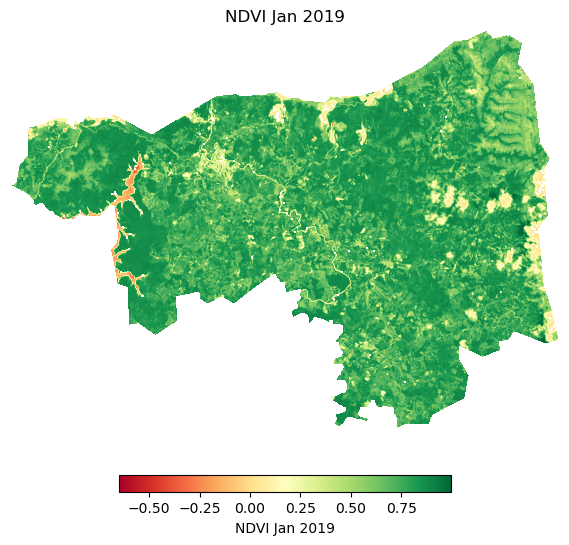

In [20]:
#Calculate ndvi 
ndvi_jan_07_2k19 = GeospatialProcessor.calculate_ndvi(nirband_jan_07_2k19,redband_jan_07_2k19)
#plot ndvi
GeospatialProcessor.quick_viz(ndvi_jan_07_2k19,"NDVI Jan 2019")

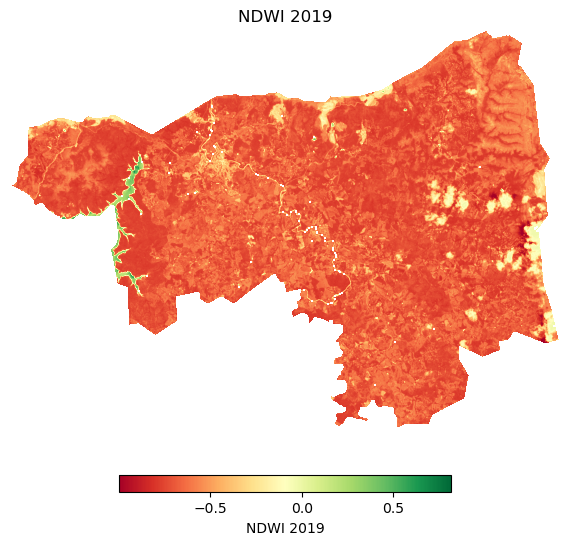

In [21]:
#Calculate ndwi 
ndwi_jan_07_2k19 =  GeospatialProcessor.calculate_ndwi(greenband_jan_07_2k19,nirband_jan_07_2k19)
#plot ndwi
GeospatialProcessor.quick_viz(ndwi_jan_07_2k19, "NDWI 2019")

**Visualizing bands After Dam Failure**

Green
{'min': 0, 'mean': 305.32327670450275, 'median': 327.0, 'max': 10136}


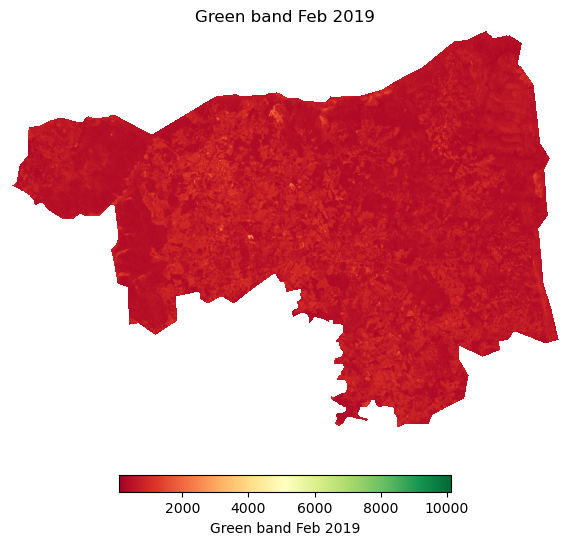

NIR
{'min': 0, 'mean': 1451.0819262401508, 'median': 1927.0, 'max': 9129}


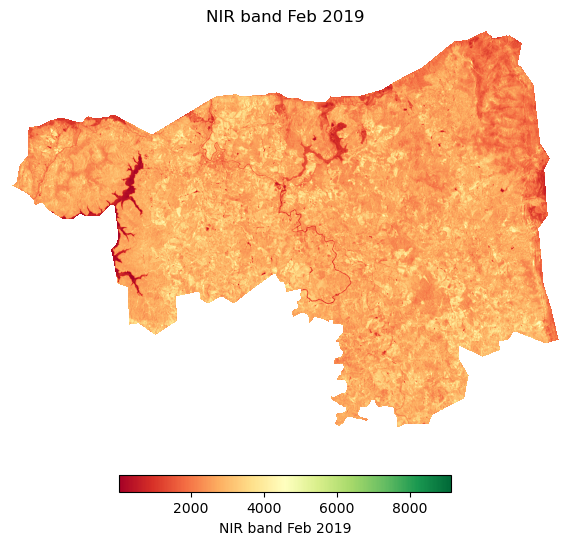

Red
{'min': 0, 'mean': 256.1609683905886, 'median': 192.0, 'max': 9656}


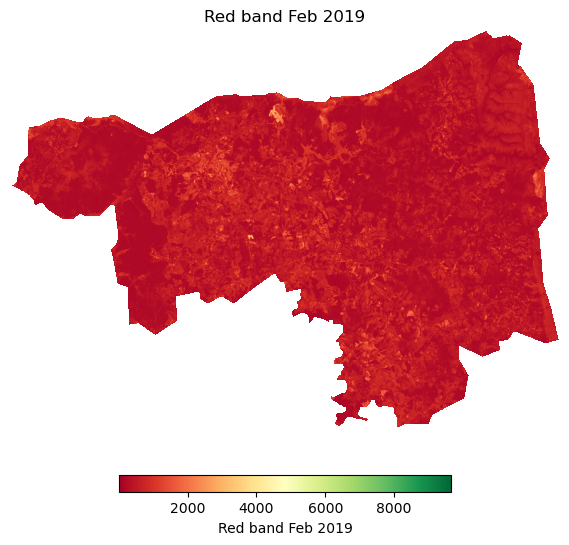

In [22]:
greenband_feb_01_2k19=processor.load_band('./data/S2_20190201/T23KNT_20190201T131241_B03_10m.tif')
nirband_feb_01_2k19=processor.load_band('./data/S2_20190201/T23KNT_20190201T131241_B08_10m.tif')
redband_feb_01_2k19=processor.load_band('./data/S2_20190201/T23KNT_20190201T131241_B04_10m.tif')
print('Green')
GeospatialProcessor.band_stats(greenband_feb_01_2k19)
GeospatialProcessor.quick_viz(greenband_feb_01_2k19,"Green band Feb 2019")
print('NIR')
GeospatialProcessor.band_stats(nirband_feb_01_2k19)
GeospatialProcessor.quick_viz(nirband_feb_01_2k19,"NIR band Feb 2019")
print('Red')
GeospatialProcessor.band_stats(redband_feb_01_2k19)
GeospatialProcessor.quick_viz(redband_feb_01_2k19,"Red band Feb 2019")

**Calculating NDVI and NDWI After Dam Failure**

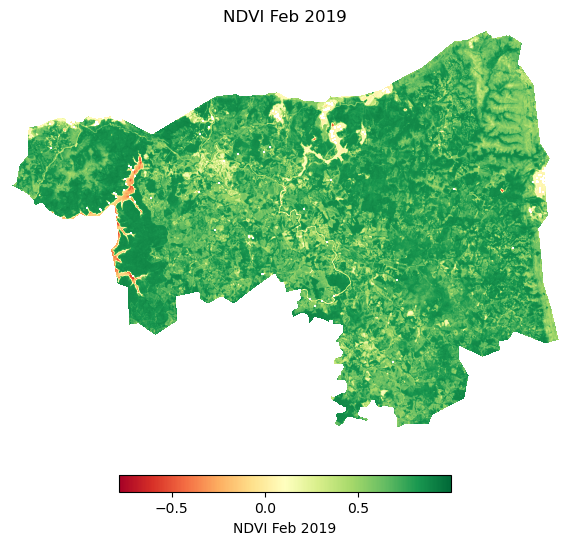

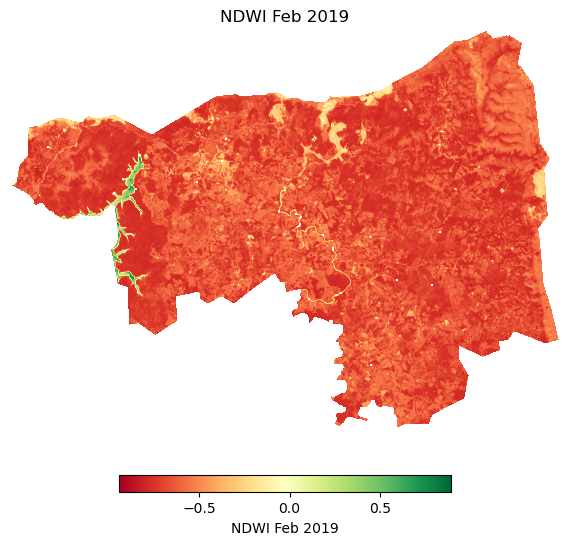

In [67]:
#Calculate ndvi 
ndvi_feb_01_2k19 = GeospatialProcessor.calculate_ndvi(nirband_feb_01_2k19,redband_feb_01_2k19)
#plot ndvi
GeospatialProcessor.quick_viz(ndvi_feb_01_2k19,"NDVI Feb 2019")
#Calculate ndwi 
ndwi_feb_01_2k19 = GeospatialProcessor.calculate_ndwi(greenband_feb_01_2k19,nirband_feb_01_2k19)
#plot ndwi
GeospatialProcessor.quick_viz(ndwi_feb_01_2k19, "NDWI Feb 2019")

<h3>4. Filtering Out Results</h3>

Checking files for date: S2_20190107
Green band path: data\S2_20190107\T23KNT_20190107T131239_B03_10m.tif
NIR band path: data\S2_20190107\T23KNT_20190107T131239_B08_10m.tif
Red band path: data\S2_20190107\T23KNT_20190107T131239_B04_10m.tif
NDVI Stats for S2_20190107
{'min': -0.6509090909088543, 'mean': 0.39473904615498545, 'median': 0.44275846484546116, 'max': 0.9981735159816439}


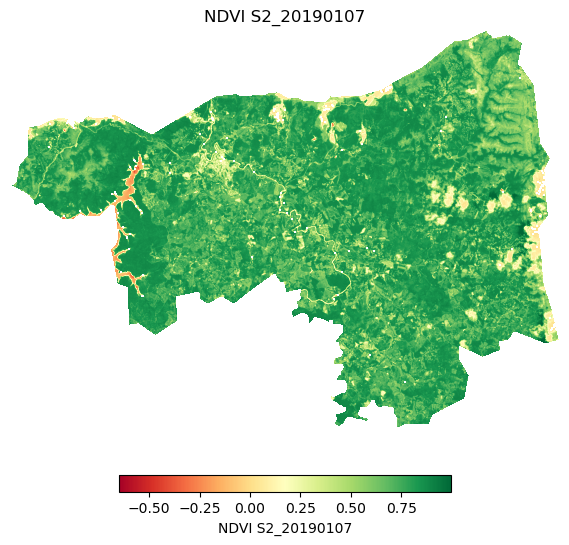

NDWI Stats for S2_20190107
{'min': -0.9991892987433725, 'mean': -0.35775448107242874, 'median': -0.4927689594356174, 'max': 0.8160919540228321}


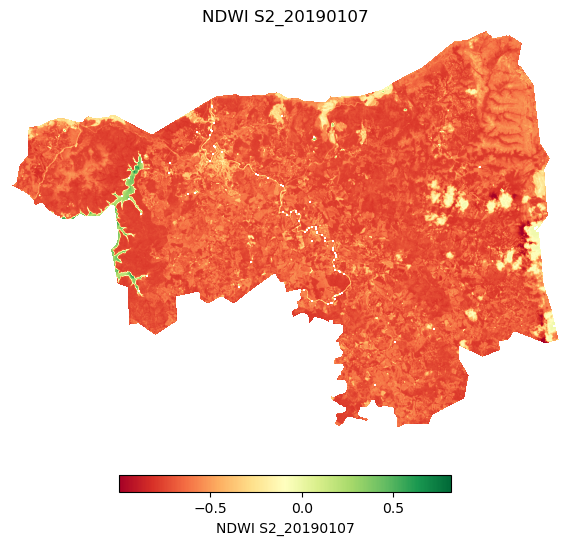

Checking files for date: S2_20190122
Green band path: data\S2_20190122\T23KNT_20190122T131241_B03_10m.tif
NIR band path: data\S2_20190122\T23KNT_20190122T131241_B08_10m.tif
Red band path: data\S2_20190122\T23KNT_20190122T131241_B04_10m.tif
NDVI Stats for S2_20190122
{'min': -0.8124999999997179, 'mean': 0.3740517808226549, 'median': 0.33009460496035975, 'max': 0.9993704752911237}


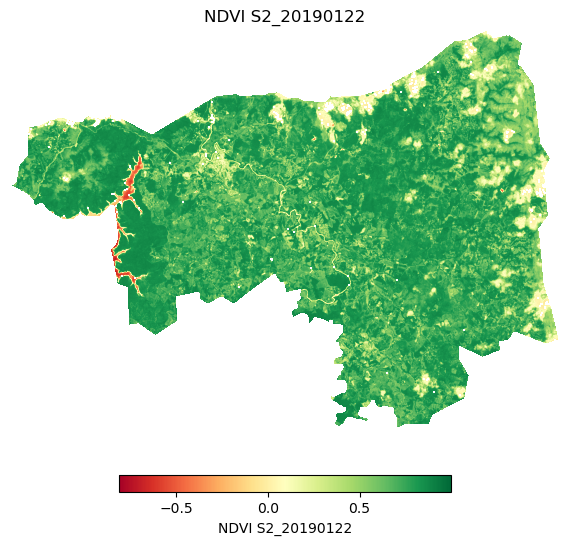

NDWI Stats for S2_20190122
{'min': -0.9993704752911237, 'mean': -0.3374356714482117, 'median': -0.3818976586748902, 'max': 0.9072164948452048}


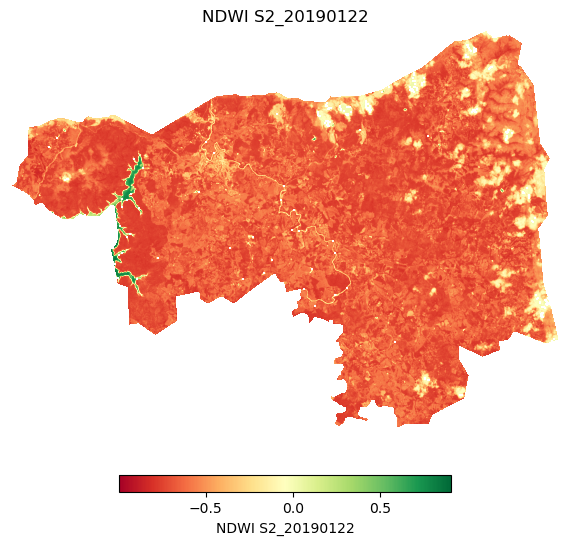

Checking files for date: S2_20190201
Green band path: data\S2_20190201\T23KNT_20190201T131241_B03_10m.tif
NIR band path: data\S2_20190201\T23KNT_20190201T131241_B08_10m.tif
Red band path: data\S2_20190201\T23KNT_20190201T131241_B04_10m.tif
NDVI Stats for S2_20190201
{'min': -0.7847533632283477, 'mean': 0.38303552701388105, 'median': 0.44341552166325265, 'max': 0.9992514970059506}


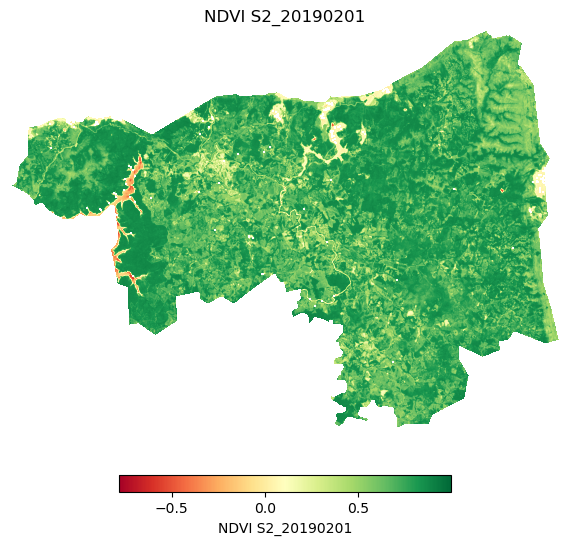

NDWI Stats for S2_20190201
{'min': -0.9475890985324616, 'mean': -0.3544077026109575, 'median': -0.5021032504779923, 'max': 0.8963282937363075}


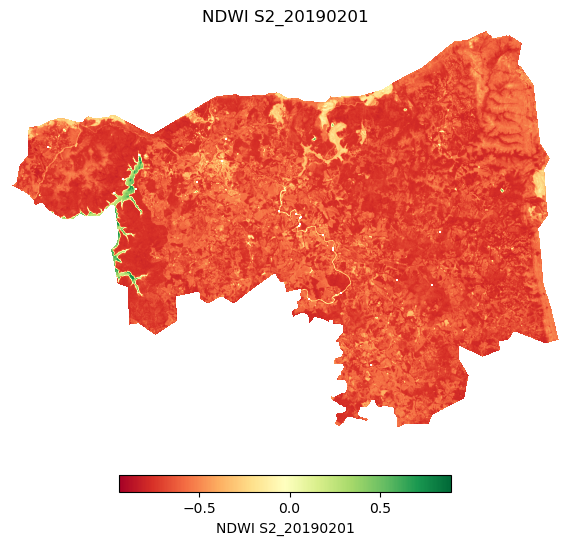

Checking files for date: S2_20200421
Green band path: data\S2_20200421\T23KNT_20200421T131239_B03_10m.tif
NIR band path: data\S2_20200421\T23KNT_20200421T131239_B08_10m.tif
Red band path: data\S2_20200421\T23KNT_20200421T131239_B04_10m.tif
NDVI Stats for S2_20200421
{'min': -0.286780851998237, 'mean': 0.24332568838324758, 'median': 0.2973626418270513, 'max': 0.7130927527587164}


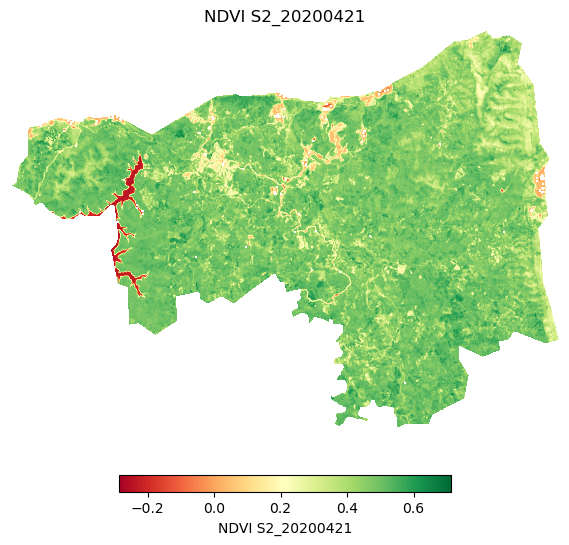

NDWI Stats for S2_20200421
{'min': -0.646953002023829, 'mean': -0.22590184229173632, 'median': -0.31109657728362083, 'max': 0.3044482957827757}


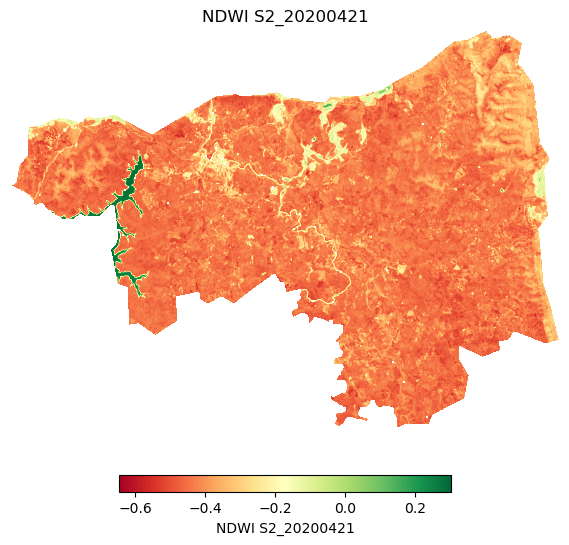

Checking files for date: S2_20210317
Green band path: data\S2_20210317\T23KNT_20210317T131239_B03_10m.tif
NIR band path: data\S2_20210317\T23KNT_20210317T131239_B08_10m.tif
Red band path: data\S2_20210317\T23KNT_20210317T131239_B04_10m.tif
NDVI Stats for S2_20210317
{'min': -0.3042415779368074, 'mean': 0.2379960761538971, 'median': 0.1883959620008522, 'max': 0.999999999999929}


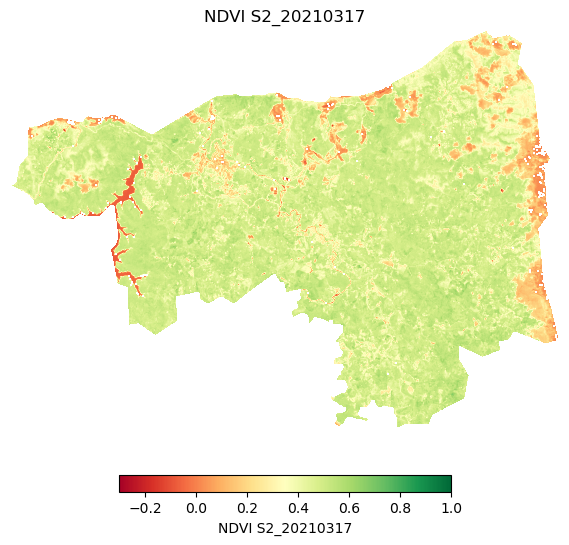

NDWI Stats for S2_20210317
{'min': -0.7010249468187836, 'mean': -0.22026890112767047, 'median': -0.2089274643521351, 'max': 0.3298094310752493}


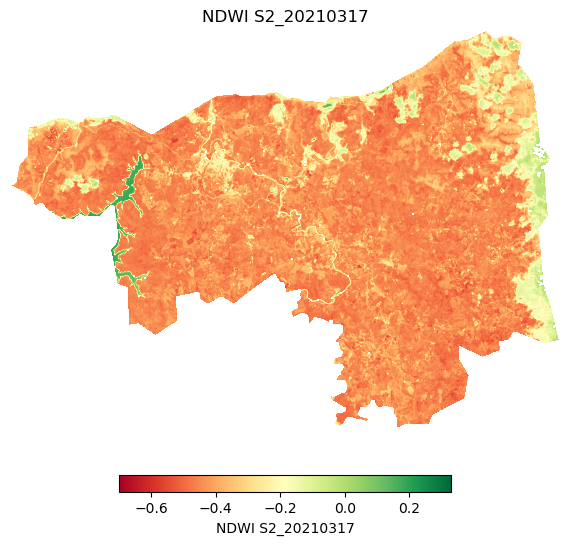

Checking files for date: S2_20220327
Green band path: data\S2_20220327\T23KNT_20220327T131251_B03_10m.tif
NIR band path: data\S2_20220327\T23KNT_20220327T131251_B08_10m.tif
Red band path: data\S2_20220327\T23KNT_20220327T131251_B04_10m.tif
NDVI Stats for S2_20220327
{'min': -0.4223692371304484, 'mean': 0.20960513201204414, 'median': 0.1369088827468075, 'max': 0.9999999999999186}


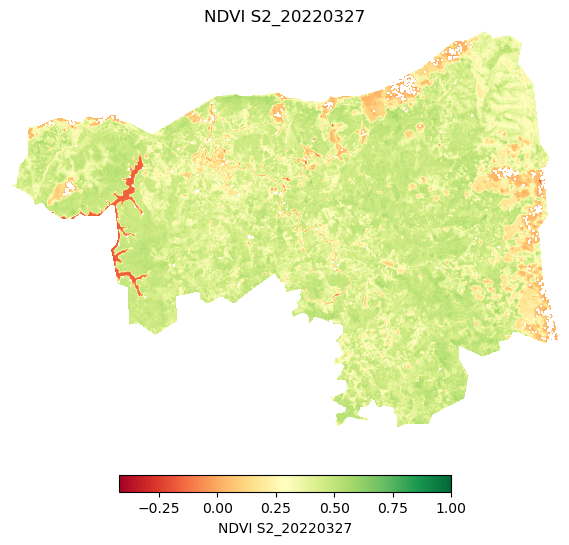

NDWI Stats for S2_20220327
{'min': -0.9999999999999236, 'mean': -0.19777689891447825, 'median': -0.16242975648915808, 'max': 0.37784342688330314}


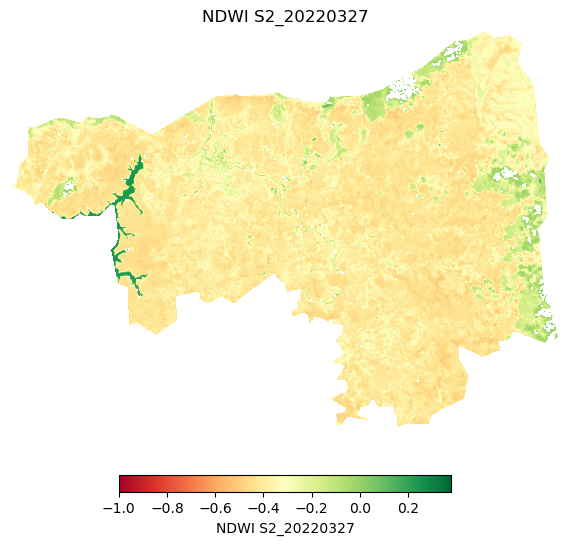

In [23]:
# Directory containing data and output folder
base_path = './data'
output_folder = 'output_imgs'
meta_src = './data/S2_20190107/T23KNT_20190107T131239_B04_10m.tif'

# Process all NDVI and NDWI images
GeospatialProcessor.process_ndvi_ndwi(base_path, output_folder, meta_src)

<h3>5. Processing Images and Visualizing it</h3>

In [28]:
# Defining directories and parameters for NDVI
ndvi_input_dir = 'ndvi_imgs'
ndvi_gif = 'animated/ndvi.gif'
ndvi_cmap = 'YlGn'
ndvi_colorbar_label = 'NDVI'

# Creating NDVI animation
GeospatialProcessor.create_animation(ndvi_input_dir, ndvi_gif, ndvi_cmap, ndvi_colorbar_label)

# Defining directories and parameters for NDWI
ndwi_input_dir = 'ndwi_imgs'
ndwi_gif = 'animated/ndwi.gif'
ndwi_cmap = 'OrRd'
ndwi_colorbar_label = 'NDWI'

# Creating NDWI animation
GeospatialProcessor.create_animation(ndwi_input_dir, ndwi_gif, ndwi_cmap, ndwi_colorbar_label)

# Displaying the generated GIFs
try:
    # Displaying NDVI GIF
    display(HTML(f'<img src="{ndvi_gif}?{os.path.getmtime(ndvi_gif)}" alt="NDVI Animation" loop>'))

    # Displaying NDWI GIF
    display(HTML(f'<img src="{ndwi_gif}?{os.path.getmtime(ndwi_gif)}" alt="NDWI Animation" loop>'))
except Exception as e:
    print(f"Error displaying GIFs: {e}")


Checking input directory: C:\Users\alhassan\Desktop\Vegetation_monitoring_project\ndvi_imgs
Processing: ndvi_S2_20190107
Processing: ndvi_S2_20190122
Processing: ndvi_S2_20190201
Processing: ndvi_S2_20200421
Processing: ndvi_S2_20210317
Processing: ndvi_S2_20220327
Checking input directory: C:\Users\alhassan\Desktop\Vegetation_monitoring_project\ndwi_imgs
Processing: ndwi_S2_20190107
Processing: ndwi_S2_20190122
Processing: ndwi_S2_20190201
Processing: ndwi_S2_20200421
Processing: ndwi_S2_20210317
Processing: ndwi_S2_20220327


<h3>5. Conclusions</h3>

Although only a handful of images were selected for this project due to cloud coverage and the scope of our analysis, it is still possible to observe significant changes over time. Despite the sparse timeline, the difference between the pre-collapse and post-collapse scenes is evident. The general area remained relatively stable, but the region initially affected by the collapse, as captured in the February 7th image, has not shown signs of recovery. The impact of the massive mudflow is still visible in the final frame.

The scars of the mudflow are clearly etched into the landscape, indicating that the area has not yet healed from the disaster. This persistent damage underscores the long-term environmental impact of the collapse. To gain a deeper understanding of the event's consequences, I plan to conduct a more detailed analysis of the data. By examining the numerical data more closely, we can uncover further insights into the broader effects of this environmental catastrophe.